C:\Users\JOHITH RAJ S S\AppData\Local\Temp\ipykernel_21144\452879969.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df['DOD'] = pd.to_datetime(df['DOD'], format='%Y-%m-%d', errors='ignore')
C:\Users\JOHITH RAJ S S\AppData\Local\Temp\ipykernel_21144\452879969.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(round(((pd.to_datetime('2009-12-01', format='%Y-%m-%d') - df['DOB']).dt.days) /

   Provider  PotentialFraud  InscClaimAmtReimbursed  DeductibleAmtPaid  \
0  PRV51001               0                  104640             5340.0   
1  PRV51003               1                  605670            66286.0   
2  PRV51004               0                   52170              310.0   
3  PRV51005               1                  280910             3700.0   
4  PRV51007               0                   33710             3264.0   

                               RenalDiseaseIndicator  NoOfMonths_PartACov  \
0                          YYY0000000YY0000000YY0Y00                  300   
1  000000000Y00Y000000000YY00000000YY00YY0000000Y...                 1560   
2  00000000000000Y0000Y00000Y00000000000000000000...                 1768   
3  00000000000000000Y0000000000000000000000000000...                13872   
4  0000000000Y0000000000Y000YY0Y00000000000000000...                  852   

   NoOfMonths_PartBCov  ChronicCond_Alzheimer  ChronicCond_Heartfailure  \
0                

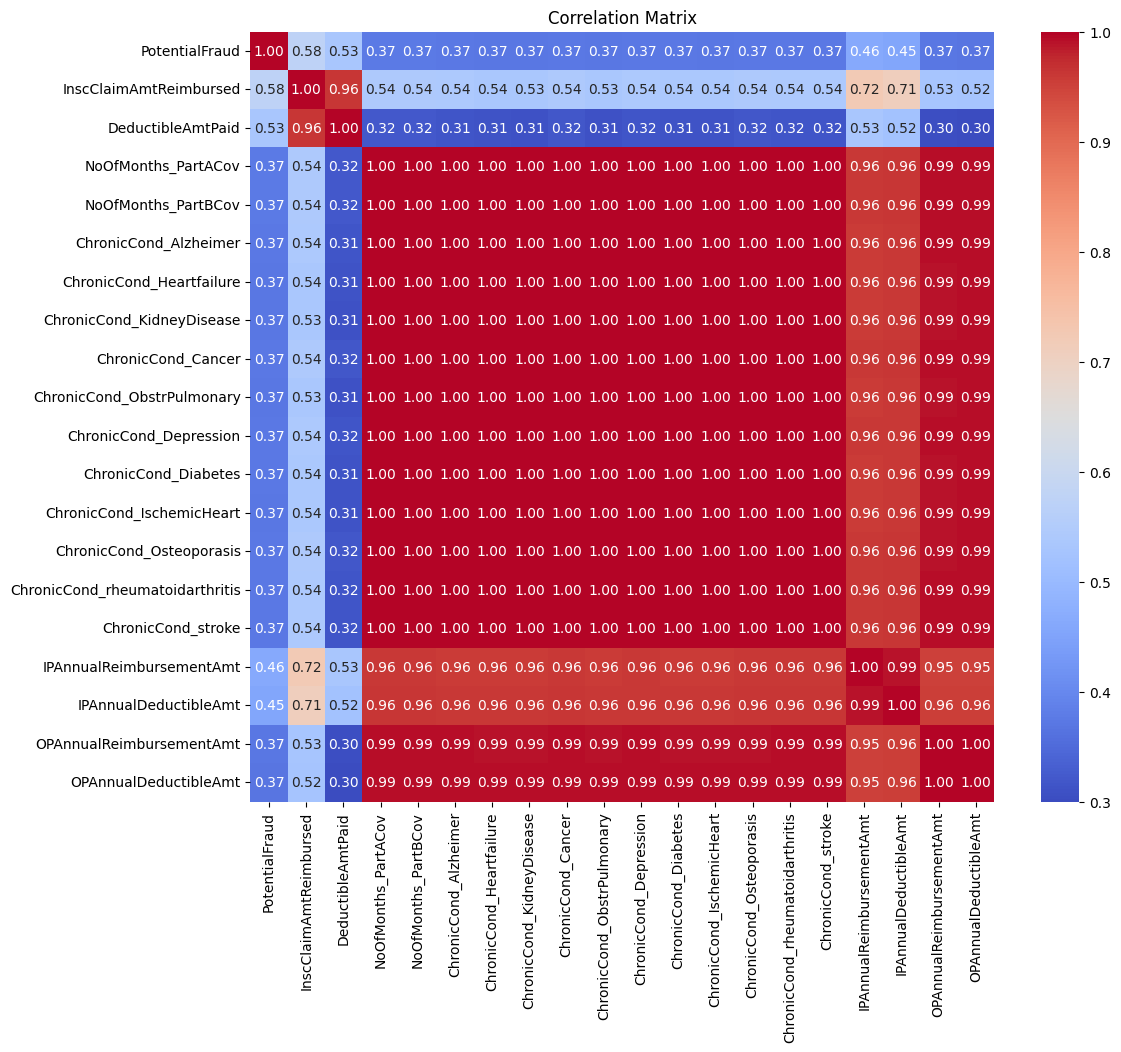

Class distribution in training data:
PotentialFraud
0    4904
1     506
Name: count, dtype: int64
Before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
After SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94       981
           1       0.47      0.77      0.59       101

    accuracy                           0.90      1082
   macro avg       0.72      0.84      0.76      1082
weighted avg       0.93      0.90      0.91      1082

Confusion Matrix:
 [[894  87]
 [ 23  78]]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load datasets
Train=pd.read_csv(r"C:\Users\JOHITH RAJ S S\OneDrive\Desktop\thrisha dataset\Train-1542865627584.csv")
Train_Beneficiarydata=pd.read_csv(r"C:\Users\JOHITH RAJ S S\OneDrive\Desktop\thrisha dataset\Train_Beneficiarydata-1542865627584.csv")
Train_Inpatientdata=pd.read_csv(r"C:\Users\JOHITH RAJ S S\OneDrive\Desktop\thrisha dataset\Train_Inpatientdata-1542865627584.csv")
Train_Outpatientdata=pd.read_csv(r"C:\Users\JOHITH RAJ S S\OneDrive\Desktop\thrisha dataset\Train_Outpatientdata-1542865627584.csv")



Test=pd.read_csv(r"C:\Users\JOHITH RAJ S S\OneDrive\Desktop\thrisha dataset\Test-1542969243754.csv")
Test_Beneficiarydata=pd.read_csv(r"C:\Users\JOHITH RAJ S S\OneDrive\Desktop\thrisha dataset\Test_Beneficiarydata-1542969243754.csv")
Test_Inpatientdata=pd.read_csv(r"C:\Users\JOHITH RAJ S S\OneDrive\Desktop\thrisha dataset\Test_Inpatientdata-1542969243754.csv")
Test_Outpatientdata=pd.read_csv(r"C:\Users\JOHITH RAJ S S\OneDrive\Desktop\thrisha dataset\Test_Outpatientdata-1542969243754.csv")

# Process DOB and DOD to calculate age
for df in [Train_Beneficiarydata, Test_Beneficiarydata]:
    df['DOB'] = pd.to_datetime(df['DOB'], format='%Y-%m-%d')
    df['DOD'] = pd.to_datetime(df['DOD'], format='%Y-%m-%d', errors='ignore')
    df['Age'] = round(((df['DOD'] - df['DOB']).dt.days) / 365)
    df['Age'].fillna(round(((pd.to_datetime('2009-12-01', format='%Y-%m-%d') - df['DOB']).dt.days) / 365), inplace=True)

# Determine whether deceased
for df in [Train_Beneficiarydata, Test_Beneficiarydata]:
    df['WhetherDead'] = df['DOD'].notna().astype(int)

# Combine inpatient and outpatient data
def combine_patient_data(outpatient, inpatient):
    return pd.merge(outpatient, inpatient, how='outer', on=[
        'BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
        'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
        'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
        'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
        'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
        'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
        'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
        'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
        'ClmAdmitDiagnosisCode'
    ])

Train_Allpatientdata = combine_patient_data(Train_Outpatientdata, Train_Inpatientdata)
Test_Allpatientdata = combine_patient_data(Test_Outpatientdata, Test_Inpatientdata)

# Merge patient data with beneficiary details
Train_AllPatientDetailsdata = pd.merge(Train_Allpatientdata, Train_Beneficiarydata, on='BeneID', how='inner')
Test_AllPatientDetailsdata = pd.merge(Test_Allpatientdata, Test_Beneficiarydata, on='BeneID', how='inner')

# Merge provider details with patient data
Train_ProviderWithPatientDetailsdata = pd.merge(Train, Train_AllPatientDetailsdata, on='Provider')
Test_ProviderWithPatientDetailsdata = pd.merge(Test, Test_AllPatientDetailsdata, on='Provider')

# Handle missing values
Train_ProviderWithPatientDetailsdata.fillna(0, inplace=True)
Test_ProviderWithPatientDetailsdata.fillna(0, inplace=True)

# Remove unnecessary columns
columns_to_remove = [
    'BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'AttendingPhysician',
    'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
    'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
    'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
    'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
    'ClmProcedureCode_5', 'ClmProcedureCode_6', 'ClmAdmitDiagnosisCode', 'AdmissionDt',
    'DischargeDt', 'DiagnosisGroupCode', 'DOB', 'DOD', 'State', 'County'
]
Train_category_removed = Train_ProviderWithPatientDetailsdata.drop(columns=columns_to_remove)
Test_category_removed = Test_ProviderWithPatientDetailsdata.drop(columns=columns_to_remove)

# Convert gender and race to categorical
for df in [Train_category_removed, Test_category_removed]:
    df['Gender'] = df['Gender'].astype('category')
    df['Race'] = df['Race'].astype('category')
    df = pd.get_dummies(df, columns=['Gender', 'Race'], drop_first=True)

# Encode PotentialFraud
Train_category_removed['PotentialFraud'].replace(['Yes', 'No'], ['1', '0'], inplace=True)
Train_category_removed['PotentialFraud'] = Train_category_removed['PotentialFraud'].astype(int)

# Grouping by Provider for aggregation
columns_to_aggregate = [
    'InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'RenalDiseaseIndicator',
    'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
    'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
    'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes',
    'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
    'ChronicCond_stroke', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
    'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt'
]

# Group and aggregate for train and test data
Train_category_removed_groupedbyProv_PF = Train_category_removed.groupby(
    ['Provider', 'PotentialFraud'], as_index=False
).agg({col: 'sum' for col in columns_to_aggregate})

Test_category_removed_groupedbyProv_PF = Test_category_removed.groupby(
    ['Provider'], as_index=False
).agg({col: 'sum' for col in columns_to_aggregate})

# Now Train_category_removed_groupedbyProv_PF and Test_category_removed_groupedbyProv_PF
# can be used for further analysis or modeling.
print(Train_category_removed_groupedbyProv_PF.head())
print(Test_category_removed_groupedbyProv_PF.head())

# Data Visualization
numeric_cols = Train_category_removed_groupedbyProv_PF.select_dtypes(include=[np.number])
correlation_matrix = numeric_cols.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Define features and target variable
X = Train_category_removed_groupedbyProv_PF.drop(columns=['Provider','PotentialFraud'])
y = Train_category_removed_groupedbyProv_PF['PotentialFraud']

# Check class distribution
print("Class distribution in training data:")
print(y.value_counts())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.drop(columns=['RenalDiseaseIndicator']))
X_test = scaler.transform(X_test.drop(columns=['RenalDiseaseIndicator']))

# Check for class imbalance and apply SMOTE if needed
print('Before SMOTE:', y_train.value_counts())
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', pd.Series(y_train_resampled).value_counts())

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Save the model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)


In [3]:
import pandas as pd
approved_samples = Train_category_removed_groupedbyProv_PF[Train_category_removed_groupedbyProv_PF['PotentialFraud'] == 1]
not_approved_samples = Train_category_removed_groupedbyProv_PF[Train_category_removed_groupedbyProv_PF['PotentialFraud'] == 0]


print("Approved Samples (PotentialFraud = 1):")
print(approved_samples.head())  

print("\nNot Approved Samples (PotentialFraud = 0):")
print(not_approved_samples.head())  


Approved Samples (PotentialFraud = 1):
    Provider  PotentialFraud  InscClaimAmtReimbursed  DeductibleAmtPaid  \
1   PRV51003               1                  605670            66286.0   
3   PRV51005               1                  280910             3700.0   
13  PRV51021               1                  348830            31492.0   
25  PRV51037               1                  342230            25524.0   
37  PRV51052               1                   30800             2346.0   

                                RenalDiseaseIndicator  NoOfMonths_PartACov  \
1   000000000Y00Y000000000YY00000000YY00YY0000000Y...                 1560   
3   00000000000000000Y0000000000000000000000000000...                13872   
13  0Y000000YYY00000YYYYYYYY00000YY0YY000000Y0000Y...                 3072   
25  000000000000000000000000Y00000000YYYYYYY000Y00...                 5436   
37     0000000YY0000Y000000Y00YY0YY00000000000000Y000                  540   

    NoOfMonths_PartBCov  ChronicCond_Alzh

In [4]:
import pandas as pd
columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid',
           'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
           'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
           'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
           'ChronicCond_Depression', 'ChronicCond_Diabetes',
           'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
           'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
           'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']


input_data_df_not_approved = pd.DataFrame([[  
    2000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000,0,500,0]], columns=columns)

predictions = rf_model.predict(input_data_df_not_approved)
pred_probabilities = rf_model.predict_proba(input_data_df_not_approved)


new_threshold = 0.6
prediction_class = 1 if pred_probabilities[0][1] > new_threshold else 0

print(f"Predicted Class with New Threshold: {'Approved' if prediction_class == 1 else 'Not Approved'}")
print(f"Predicted Probabilities: {pred_probabilities}")
print(f"Direct Model Prediction: {'Approved' if predictions[0] == 1 else 'Not Approved'}")



Predicted Class with New Threshold: Not Approved
Predicted Probabilities: [[0.47 0.53]]
Direct Model Prediction: Approved


C:\Users\JOHITH RAJ S S\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\JOHITH RAJ S S\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [6]:
import pandas as pd

columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid',
           'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
           'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
           'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
           'ChronicCond_Depression', 'ChronicCond_Diabetes',
           'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
           'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
           'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']

input_data_df_approved = pd.DataFrame([[605670, 66286, 1560, 1567, 208, 184, 200, 0, 0, 0, 0, 0, 0, 0, 0, 999000, 122948, 353520, 97300]], columns=columns)



predictions = rf_model.predict(input_data_df_approved)
pred_probabilities = rf_model.predict_proba(input_data_df_approved)


new_threshold = 0.6
prediction_class = 1 if pred_probabilities[0][1] > new_threshold else 0


print(f"Predicted Class with New Threshold: {'Approved' if prediction_class == 1 else 'Not Approved'}")
print(f"Predicted Probabilities: {pred_probabilities}")
print(f"Direct Model Prediction: {'Approved' if predictions[0] == 1 else 'Not Approved'}")



Predicted Class with New Threshold: Approved
Predicted Probabilities: [[0.22 0.78]]
Direct Model Prediction: Approved


C:\Users\JOHITH RAJ S S\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\JOHITH RAJ S S\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
